# Conditional VAE

## Process

1. perform model-selection
    - without using CVAE_MODEL, perform hyperparamter grid-search
    - using the total-loss function
2. with the selected model, 
    - initilize the model in CVAE_MODEL
    - fit the model
    - save the model
3. compute DDloss
    - init CVAE_MODEL
    - load the model
    - generate patients
    - compute


In [1]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## CVAE

In [154]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

class CVAE(keras.Model):
    
    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon


    
    def __init__(self, latent_dim, input_shape, conditional_shape, **kwargs):
        
        super(CVAE, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        self.nr_markers = input_shape - conditional_shape
        self.conditional_shape = conditional_shape
        
        self.encoder = self.create_encoder(latent_dim, input_shape)
        self.decoder = self.create_decoder(latent_dim, input_shape)
    
    
    def create_encoder(self, latent_dim, input_shape):
        """
        
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
        input_shape: int
            the shape of the input data
            
        RETURNS
        -------
        encoder: keras model
            the encoder in the variational autoencoder.
        """
        # An encoder of single selfs.
        encoder_inputs = keras.Input(shape=(input_shape,), name="encoder_input")
        x = layers.Dense(10, activation="relu", name="encoder_l2")(encoder_inputs)
        x = layers.Dense(8, activation="relu", name="encoder_l3")(x)
        x = layers.Dense(6, activation="relu", name="encoder_l4")(x)

        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        
        z = CVAE.Sampling()([z_mean, z_log_var])

        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
        
    def create_decoder(self, latent_dim, input_shape):
        """
        
        PARAMETERS
        ----------
        latent_dim: int
            the dimensision of latent variable
            
        RETURNS
        -------
        decoder: keras model
            the decoder in the variational autoencoder.
        """
        decoder_inputs = keras.Input(shape=(latent_dim+self.conditional_shape,), name ="latent_variable")
        x = layers.Dense(6, activation="relu", name="decoder_l2")(decoder_inputs)
        x = layers.Dense(8, activation="relu", name="decoder_l3")(x)
        x = layers.Dense(10, activation="relu",name="decoder_l4")(x)
        decoder_outputs = layers.Dense(input_shape, activation="relu", name="output_layer")(x)
        decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
        return decoder


    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            
            condition = data[:, -self.conditional_shape:]
            
            z_mean, z_log_var, z = self.encoder(data) 
            
            
            condititonal_z = keras.layers.concatenate([z, condition], axis=1)
            conditional_reconstruction = self.decoder(condititonal_z)
            
            # Use MSE as a construction loss, to be set as a parameter.
            mse = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = mse(data, conditional_reconstruction)
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def test_step(self, data):
        x, y = data
        
        # Compute predictions
        y_pred = self(x, training=False)
        
        # Use MSE as a construction loss, to be set as a parameter.
        mse = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = mse(y, y_pred)
        
        return {"reconstruction_loss": reconstruction_loss} 
        
    def call(self, inputs):
        _, _, encoded = self.encoder(inputs)
        e = keras.layers.concatenate([encoded, inputs[:,-2:]], axis=1)
        decoded = self.decoder(e)
        return decoded

        #reconst_images = decoder.predict(np.random.normal(0,1,size=(cell_per_patient, self.latent_dim)))

class CVAE_MODEL():
    
    def __init__(self):
        pass
    
    def convert_group(self, df):
        cond = pd.get_dummies(df["group"]).astype("float32")

        data = df[df.columns.difference(["id","group"])]
        data = np.concatenate((data, cond), axis=1)

        return data, (data.shape[1], cond.shape[1]) 

    def fit(self, data_train, data_val, latent_dim, epochs, batch_size, optimizer,  **kwargs):
        """
        PARAMETERS
        ----------
        data_train : stratified training data
        data_val : statified validation data
        """
        
        # preprocess the data
        
        # training data
        data_train, (data_shape, cond_shape) = self.convert_group(data_train)
        
        # validaiton data
        data_val, _ = self.convert_group(data_val)

        
        # initilize the CVAE model
        self.model = CVAE(latent_dim, data_shape, cond_shape)
        
        # compile the model
        self.model.compile(optimizer=optimizer)
        
        
        # fit the model
        self.model.fit(data_train, epochs=epochs, batch_size=batch_size, validation_data=(data_val,data_val),  **kwargs)
    
    def save(self, filepath):
        # save the model
        self.model.save(filepath)
    
    def load(self, filepath):
        # load the model
        # set self.model
        
        # TODO if filepath exists.
        self.model = keras.models.load_model(filepath)
        
        
        
    def generate_patients(self, nr_markers, latent_dim, conditional_dim, nr_cells = 20000, nr_patients = 20, column_names=None, group=None): 
        """
        PARAMETERS
        ----------
        nr_markers : int
        latent_dim : int
        conditional_dim : int
        nr_cells : int
        nr_patients : int
        column_names : Dataframe.columns
        group : str
            "control" or "diseased"
        
        RETURNS
        -------
        
        patients : dataframe
        
        """
        if self.model:
        
            patients = np.empty(shape=(nr_patients* nr_cells, nr_markers))
            p_id = np.empty(shape=nr_patients*nr_cells, dtype="int32")

            if group == "control":
                gr = np.concatenate((np.ones(shape=(nr_cells,1)),np.zeros(shape=(nr_cells,1))), axis=1)
            else:
                gr = np.concatenate((np.zeros(shape=(nr_cells,1)),np.ones(shape=(nr_cells,1))), axis=1)

            for i in range(nr_patients):
                # patient ids
                p_id[nr_cells*i : nr_cells*(i+1)] = np.full(shape=(nr_cells), fill_value=i+1, dtype="int32")

                sample = np.random.normal(0,1, size = (nr_cells, latent_dim))
                latent_vals = np.concatenate((sample, gr),axis=1)

                # sampled patient cells
                patients[nr_cells*i : nr_cells*(i+1)] = self.model.decoder.predict(latent_vals)[:,:-conditional_dim]

            patients_df = pd.DataFrame(patients, columns=column_names)


            patients_df["id"] = p_id
            patients_df["group"] = group

            return patients_df
        
    
    def embedd(self, X):
        """
        PARAMETERS:
        ----------
        X : dataframe or numpy array
        """
        # embedd data with the encoder
        
        return self.model.encoder.predict(X)
    
    def plot_embedding(self, data, labels=None):
        
        # display a 2D plot of the digit classes in the latent space
        _, _, z = self.model.encoder.predict(data)
        color = data[:,-group_id_shape:].argmax(axis=1)
        plt.figure(figsize=(12, 10))
        plt.scatter(z[:, 0], z[:, 1], label="Embedding")
        #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
        #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
        #plt.colorbar()
        plt.legend()
        plt.xlabel("z_0")
        plt.ylabel("z_1")
        plt.show()

### CVAE - Model

In [10]:
# SELECTED HYPERPARAMETERS
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)
EPOCHS = 1
BATCH_SIZE = 128

LATENT_DIM = 2 


model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

5000/5000 [==============================] - 6s 1ms/step - loss: 1.2068 - reconstruction_loss: 0.7761 - kl_loss: 0.4307 - val_loss: 0.0000e+00


In [12]:
filepath = "GenerativeModels/CVAE_1.tf"
# Save model
model.save(filepath)
# Load Model
loaded_model = keras.models.load_model(filepath)#, custom_objects={"CVAE": CVAE}) 
#don't need the class for loading when using the default saveformat

INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


In [15]:
generated_control = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "control")
generated_diseased = generate_patients(loaded_model, input_shape-group_id_shape, LATENT_DIM, group_id_shape, 20, 20, cells.columns.difference(["id","group"]), "diseased")

generated = generated_control.append(generated_diseased)

## Final model for export

In [48]:
modeler = CVAE_MODEL()
modeler.fit(cells,LATENT_DIM, EPOCHS, BATCH_SIZE, OPTIMIZER)
filepath = "GenerativeModels/CVAE_1.tf"
modeler.save(filepath)
modeler.load(filepath)
#modeler.generate_patients()

5000/5000 [==============================] - 7s 1ms/step - loss: 1.4720 - reconstruction_loss: 1.4715 - kl_loss: 5.1036e-04 - val_loss: 0.0000e+00
INFO:tensorflow:Assets written to: GenerativeModels/CVAE_1.tf/assets


## Visualisation

In [35]:
# Add condition
gi = pd.get_dummies(generated["group"]).astype("float32")

d = generated[generated.columns.difference(["id","group"])]
d = np.concatenate((d, gi), axis=1)

In [36]:
def plot_label_clusters(encoder, decoder, data, labels=None):
    # display a 2D plot of the digit classes in the latent space
    _, _, z = encoder.predict(data)
    color = data[:,-group_id_shape:].argmax(axis=1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], label="Embedding")
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], label="Means")
    #plt.scatter(z_var[:,0], z_var[:,1], label="Variance")
    #plt.colorbar()
    plt.legend()
    plt.xlabel("z_0")
    plt.ylabel("z_1")
    plt.show()

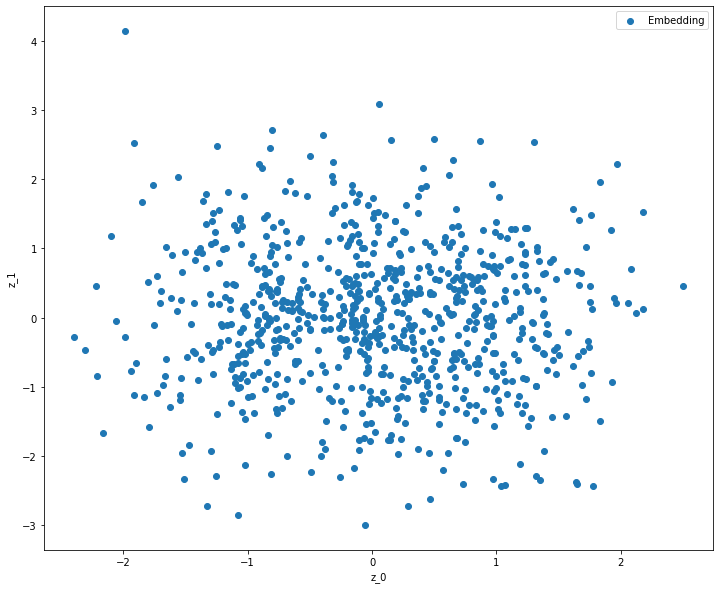

In [37]:
plot_label_clusters(loaded_model.encoder, loaded_model.decoder, d)

### TODO
Hyper parameter search
- get training and test data
- clustering
- 



# Hyperparameter search

In [2]:
import pandas as pd

## DATA

In [16]:
cells = pd.read_csv("ModifiedDATA/scaled_ra.csv")

## Hyperparameters

In [98]:
def rand_dec_layers(size, rang):
    """
    PARAMETERS
    ----------
    size:
    rang: range
    
    RETURNS
    -------
    list of unique random values between a range, sorted
    """
    s,e = rang
    sampled_list = random.choices(range(s,e),k = size)
    sampled_list.sort()
    return sampled_list

In [157]:
def dropout_layers(percent, layers):
    """
    PARAMETERS
    ----------
    percent : double 
        between 0 and 1
    layers : int
        number of layers
    
    RETURNS
    -------
    list of int which layers should have dropouts
    """
    a = list(range(layers))
    random.shuffle(a)
    return a[:int(layers*percent)]

In [170]:
# Hyperparameters

 # Architecture 
e_layers = (2,12) # there should be atleast two layers 
e_units = (2,12)  # there should be atleast two units

hp_encoder = { "nr_hidden_layers": list(range(*e_layers)) , 
               "units_per_layer" : lambda n_layers : rand_dec_layers(n_layers , e_units) , # depends on the choice of nr_hidden_layers 
               "activation_function": ["relu", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
               #"reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}
                "dropout_layer" : lambda n_layers : dropout_layers(0.2, n_layers )} # depends on the choice of nr_hidden_layers. 


d_layers = (2,12) # there should be atleast two layers 
d_units = (2,12) # there should be atleast two layers

hp_decoder = { "nr_hidden_layers": list(range(*d_layers)) , 
               "units_per_layer" : lambda n_layers : rand_dec_layers(n_layers , d_units) , # depends on the choice of nr_hidden_layers 
               "activation_function": ["relu", "sigmoid", "tanh", "selu", "softsign", "elu", "softmax"],
               #"reconstruction_loss": ["mse","mae","mape","msle", "logCos"]}
                "dropout_layer" : lambda n_layers : dropout_layers(0.2, n_layers )} # depends on the choice of nr_hidden_layers

latent_dim = 2 # should be a multiple of 2. One for the mean and one for the standard diviation of the gaussian
conditional_dim = 0 # used if the data is conditional on somethings. This is the dimension of the onehotencoding of that conditioning.


 # Learning algorithm
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)

optimizers = {"SGD", "Adagrad","RMSprop", "Adam","Adamax","Adadelta","Nadam","Ftrl"}

epochs = 1
batch_size = 128

### Notes

- dim_per_layer is function that takes nr_hidden_layers as input and produceses a list of numbers
- What is the justification of the activation functions?
    - "relu" $max(x,0)$ 
    - "sigmoid" $sigmoid(x) = 1 / (1 + exp(-x))$ 
        - for small values (<-5) return ~0 and for large values (>5) ~1
        - range(0,1)
        - equivalent to 2-element softmax
    - "tanh" $tanh(x)$ 
        - Hyperbolic tangent 
        - range(-1,1)
    - "selu"
        - Scaled Exponential Linear Unit
    - "softplus" $softplus(x) = log(exp(x) + 1)$
        - A smooth approximation to the ReLU
    - "softsign"
        - A less strict sigmoid
    - "elu"
        - The exponential linear unit (ELU) with alpha > 0 is: x if x > 0 and alpha * (exp(x) - 1) if x < 0 
        - ELUs diminish the vanishing gradient effect.
        - The ELU hyperparameter alpha controls the value to which an ELU saturates for negative net inputs.
    - "softmax" $exp(x) / tf.reduce_sum(exp(x))$
        - converts tensor to categorical probablities
        - output vector range(0,1) and sum to 1
    - "exponential"
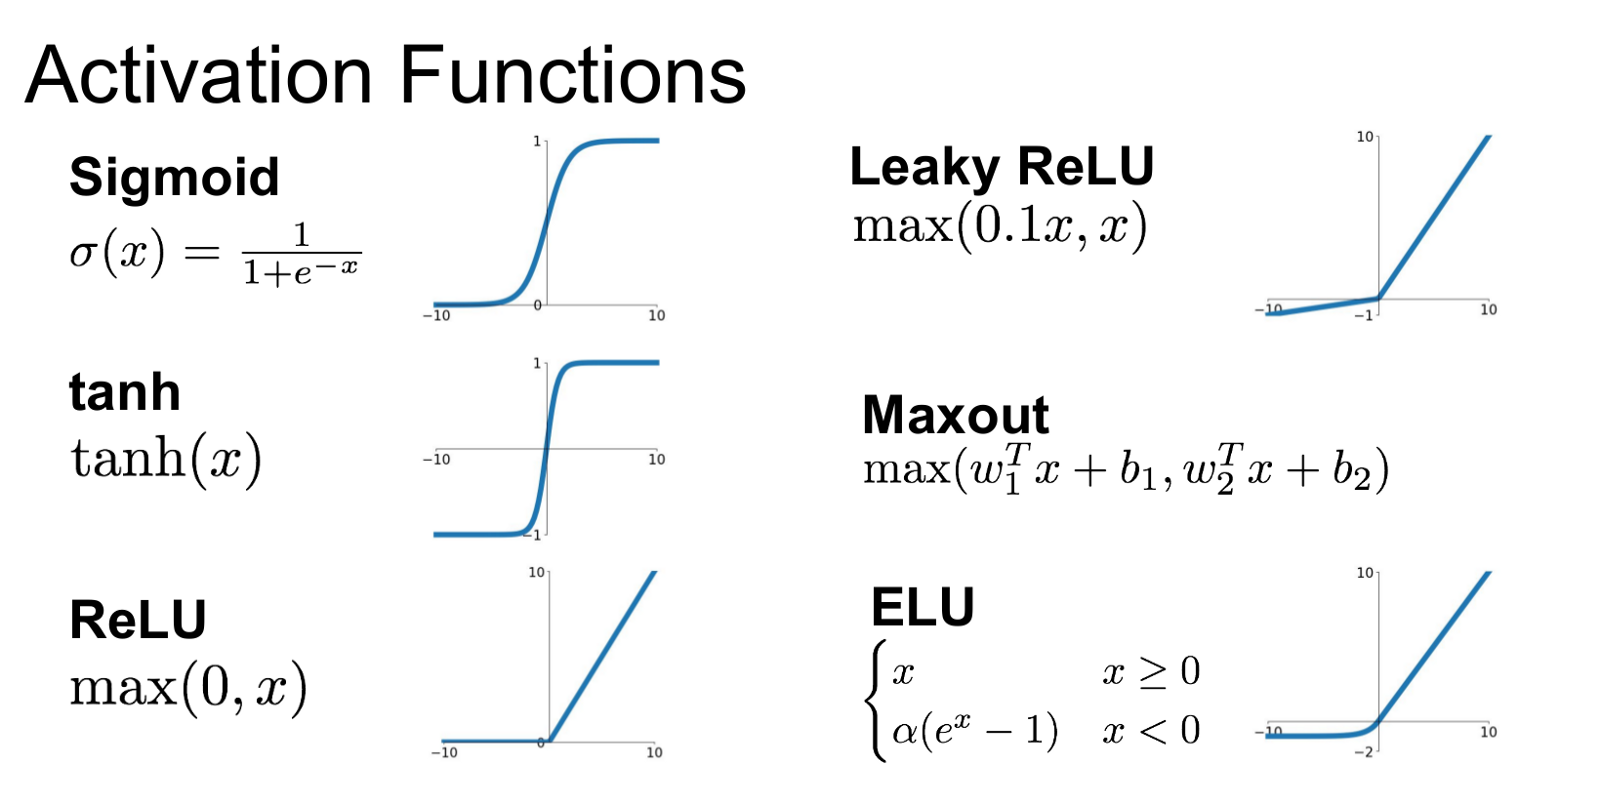
- reconstruction loss:
    - "mse" 
        - incorporates both the variance and bias of the error
        - 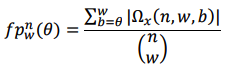
        - If we had a gaussian distribution: the MSE is cross-entropy between the empirical distribution and a gaussian model. src: Deep Learning (by Ian Goodfellow, Yoshua Bengio and Aaron Courville)
            
        > Any loss consisting of a negative log-likelihood is a cross-entropy between the empirical distribution defined by the training set and the probability distribution defined by model. For example, mean squared error is the cross-entropy between the empirical distribution and a Gaussian model."
- [optimizers](https://ruder.io/optimizing-gradient-descent/index.html)
    - ["SGD"](https://dominikschmidt.xyz/nesterov-momentum/)
        - Gradient descent (with momentum) optimizer.
        - Update rule for parameter w with gradient g when momentum is 0:
        > $w = w - learning\_rate * g$
        - Update rule when momentum is larger than 0:
        - velocity = momentum * velocity - learning_rate * g
        > $w = w + velocity$
        - When nesterov=True, this rule becomes:
        > $velocity = momentum * velocity - learning_rate * g$
        > $w = w + momentum * velocity - learning_rate * g$
    - "Adagrad"
        - adaptive learning rate method
    - "RMSprop" (not published) [explanation](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)
        - i.e. Root mean squared propagation
        - adaptive learning rate method
        - extension of adagrad
        - almost similar to Adadelta
        - The gist of RMSprop is to:
        > Maintain a moving (discounted) average of the square of gradients
        > Divide the gradient by the root of this average
    - "Adadelta"
        - extention of adagrad with reduced aggressiveness
        - adaptive learning rate
        - Instead of inefficiently storing  previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients.
    - ["Adam"](https://arxiv.org/abs/1412.6980) [explanation](https://towardsdatascience.com/understanding-gradient-descent-and-adam-optimization-472ae8a78c10)
        - i.e. Adaptive Momentum estimation
        - adaptive learning rate method
        - combination of RMSprop and Momentum
        - Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
        - "well suited for problems that are large in terms of data and/or parameters"
    - "Mometum" (not in keras)
    - "NAG" (not in keras)
        - Nesterov accelerated gradient
    - "Adamax"
        - generalization of Adam, with lp-norm instead of l2-norm
    - "Nadam"
        - combination of Adam and NAG
    - "Ftrl"
    - "AMSgrad"
        - improvement for machinetranslation and object recognistion
- Regularization: <b style="color:red">TODO</b>
    - Dropout, sparcity
    - K-winner dropout
    - layer weight regularizer
    - gaussian noice
    - spacital dropout

### HOW: 
- grid search using [keraswrapper](https://stackoverflow.com/questions/49823192/autoencoder-gridsearch-hyperparameter-tuning-keras) with sklearns gridsearch algorithm 
- using [keras tuner](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/)

In [ ]:
# SELECTED HYPERPARAMETERS
model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

In [146]:
%%time


# Load data

df_pf = pd.read_csv("ModifiedDATA/RA/Scaled/unstim_phenofunc.csv")

# subsample data

SUBSAMPLE_SIZE = 10000 # nr_cells per patient

df = df_pf.groupby('id', group_keys=False).sample(n=SUBSAMPLE_SIZE, replace=False, random_state=2)


# split size

RANDOM_SEED = 42

train_dd, test_dd = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['id'])

trian_m , test = train_test_split(train_dd, test_size=0.2, random_state=RANDOM_SEED, stratify=train_dd['id'])

train, val = train_test_split(trian_m, test_size=0.2, random_state=RANDOM_SEED, stratify=trian_m['id'])

data = { "train": train,
         "val": val,
         "test": test,
         "test_dd":test_dd
       }

# use val + test for training dim_red
# use train + val for model selection based on density estimation
# use test for model selection based of dd-loss
# use test_dd for estimating the double date loss for the "ideal model".

# get the markers

# Taken from the paper
phenotyping = ['CD20','CD3','CD4','CD8a','CD45RA', 'CD56', 
               'CD16', 'CD14', 'CD61', 'CD11c','CD123', 'HLA-DR', 'CD45']

functional = ['Caspase3', 'CD86','p-p38','p-Erk','p-Akt','p-cJun','p-NFkB','IkBa','CD120a','CD120b']

functional_columns = list(filter((lambda x : any([i in x for i in functional])), df_pf.columns))
phenotyping_columns = list(filter((lambda x : any([i in x for i in phenotyping])), df_pf.columns))
labels = ["id", "group"]

#df_p = data["train"][phenotyping_columns + labels]
#df_f = data["train"][funcitonal_columns + labels]



CPU times: user 15.2 s, sys: 2.27 s, total: 17.5 s
Wall time: 18.9 s


In [70]:
df_p = data["train"][phenotyping_columns + labels]

In [74]:
df_p.groupby("group").count()

,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,151Eu_CD123,159Tb_CD11c,160Gd_CD14,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id
group,,,,,,,,,,,,,,
control,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098,51098
diseased,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302,51302


In [ ]:
# SELECTED HYPERPARAMETERS
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)
EPOCHS = 1
BATCH_SIZE = 128


LATENT_DIM = 2 


model = CVAE(LATENT_DIM, input_shape, group_id_shape)
#model.build((None,input_shape))

model.compile(optimizer=OPTIMIZER)

model.fit(data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

In [55]:
df_pf.describe()

,142Nd_Caspase3,145Nd_CD4,146Nd_CD8a,147Sm_CD20,148Nd_CD16,150Nd_CD86,151Eu_CD123,152Sm_p-Akt,155Gd_CD120a,156Gd_p-p38,...,165Ho_CD120b,166Er_p-NFkB,167Er_p-cJun,169Tm_CD45RA,170Er_CD3,174Yb_HLA-DR,176Yb_CD56,209Bi_CD61,89Y_CD45,id
count,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,...,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06,6.389440e+06
mean,1.511458e-02,1.336185e+00,1.183599e-01,8.569858e-02,2.359777e-03,9.519454e-02,2.790618e-01,1.033918e-02,8.355197e-01,3.052695e-02,...,1.918180e+00,7.098109e-01,7.534911e-02,2.821859e+00,1.032783e-02,2.440763e-02,9.844703e-03,5.647810e+00,2.881433e-02,9.500000e+00
std,8.731911e-02,1.839810e+00,4.179470e-01,2.837203e-01,2.866244e-02,3.843423e-01,3.897042e-01,6.490172e-02,9.892413e-01,1.322164e-01,...,8.716810e-01,6.057909e-01,1.901704e-01,1.904091e+00,5.967676e-02,1.051711e-01,5.554857e-02,2.548040e-01,1.226918e-01,5.766282e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.139484e-02,0.000000e+00,...,1.396507e+00,1.559669e-01,0.000000e+00,2.276291e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.566831e+00,0.000000e+00,4.750000e+00
50%,0.000000e+00,3.824111e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.672470e-02,0.000000e+00,5.043452e-01,0.000000e+00,...,1.971310e+00,6.255888e-01,0.000000e+00,3.800661e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.651342e+00,0.000000e+00,9.500000e+00
75%,0.000000e+00,2.004228e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.605460e-01,0.000000e+00,1.185073e+00,0.000000e+00,...,2.474068e+00,1.129350e+00,0.000000e+00,4.316145e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.740956e+00,0.000000e+00,1.425000e+01
max,8.627292e+00,9.663447e+00,9.112473e+00,9.366853e+00,5.351006e+00,5.619878e+00,9.520501e+00,5.339419e+00,8.354411e+00,4.762049e+00,...,6.159187e+00,7.123796e+00,5.208274e+00,6.210354e+00,6.770521e+00,5.332920e+00,5.430301e+00,7.642630e+00,7.436270e+00,1.900000e+01


In [47]:
df_pf.values.shape

(6389440, 24)

In [150]:
from keras.callbacks import ModelCheckpoint

In [151]:
LATENT_DIM = 2
EPOCHS = 100 
BATCH_SIZE = SUBSAMPLE_SIZE//50
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(LEARNING_RATE)

modeler = CVAE_MODEL()

df_p_train, df_p_val = train_test_split(df_p, test_size=0.2, random_state=RANDOM_SEED, stratify=df_p['id'])

filepath = "GenerativeModels/CVAE_2.tf"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

modeler.fit(df_p_train, df_p_val, LATENT_DIM, EPOCHS, BATCH_SIZE, OPTIMIZER, callbacks=callbacks_list)
#filepath = "GenerativeModels/CVAE_2.tf"
#modeler.save(filepath)
#modeler.load(filepath)

Epoch 1/100
410/410 [==============================] - 1s 2ms/step - loss: 1.2584 - reconstruction_loss: 1.2571 - kl_loss: 0.0013 - val_reconstruction_loss: 1.1717

Epoch 00001: loss improved from inf to 1.26421, saving model to GenerativeModels/CVAE_2.tf
INFO:tensorflow:Assets written to: GenerativeModels/CVAE_2.tf/assets
Epoch 2/100
410/410 [==============================] - 1s 2ms/step - loss: 1.2055 - reconstruction_loss: 1.2055 - kl_loss: 3.7593e-07 - val_reconstruction_loss: 1.1723

Epoch 00002: loss did not improve from 1.26421
Epoch 3/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2051 - reconstruction_loss: 1.2051 - kl_loss: 5.3305e-08 - val_reconstruction_loss: 1.1731

Epoch 00003: loss did not improve from 1.26421
Epoch 4/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2052 - reconstruction_loss: 1.2052 - kl_loss: 3.2498e-08 - val_reconstruction_loss: 1.1712

Epoch 00004: loss did not improve from 1.26421
Epoch 5/100
410/410 [======


Epoch 00036: loss did not improve from 0.99833
Epoch 37/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2045 - reconstruction_loss: 1.2045 - kl_loss: 5.0178e-08 - val_reconstruction_loss: 1.1727

Epoch 00037: loss did not improve from 0.99833
Epoch 38/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2051 - reconstruction_loss: 1.2051 - kl_loss: 5.8662e-08 - val_reconstruction_loss: 1.1715

Epoch 00038: loss did not improve from 0.99833
Epoch 39/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2048 - reconstruction_loss: 1.2048 - kl_loss: 5.6668e-08 - val_reconstruction_loss: 1.1721

Epoch 00039: loss did not improve from 0.99833
Epoch 40/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2048 - reconstruction_loss: 1.2048 - kl_loss: 4.5900e-08 - val_reconstruction_loss: 1.1719

Epoch 00040: loss did not improve from 0.99833
Epoch 41/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2045 -

410/410 [==============================] - 1s 1ms/step - loss: 1.2036 - reconstruction_loss: 1.2036 - kl_loss: 5.5653e-08 - val_reconstruction_loss: 1.1700

Epoch 00074: loss did not improve from 0.99833
Epoch 75/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2038 - reconstruction_loss: 1.2038 - kl_loss: 3.6220e-08 - val_reconstruction_loss: 1.1692

Epoch 00075: loss did not improve from 0.99833
Epoch 76/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2031 - reconstruction_loss: 1.2031 - kl_loss: 4.7749e-08 - val_reconstruction_loss: 1.1685

Epoch 00076: loss did not improve from 0.99833
Epoch 77/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2036 - reconstruction_loss: 1.2036 - kl_loss: 4.6951e-08 - val_reconstruction_loss: 1.1693

Epoch 00077: loss did not improve from 0.99833
Epoch 78/100
410/410 [==============================] - 1s 1ms/step - loss: 1.2035 - reconstruction_loss: 1.2035 - kl_loss: 5.1773e-08 - val_reco

In [152]:

modeler.load(filepath)

In [144]:
val_accuracy_key = 'val_acc'
accuracy_key = 'acc'

#reconstruction_loss
#kl_loss

def plot_training_histories(training_histories, paramdict: dict=None, **kwargs):
    '''Plots given a list of keras training histories, gives a quick summary in plots as well'''
    fig, axes = plt.subplots(len(training_histories), 2, figsize=(12, 2.5*len(training_histories)))
    xepochs = np.arange(1, len(training_histories[0].history['loss'])+1)

    axes = axes.reshape(-1, 2)
    for i, hist in enumerate(training_histories):
        axes[i,0].plot(xepochs, hist.history['loss'], linestyle='--', **kwargs)
        axes[i,0].plot(xepochs, hist.history['kl_loss'], **kwargs)  
        axes[i,0].plot(xepochs, hist.history['reconstruction_loss'],linestyle='dashdot', **kwargs)    
        axes[i,0].plot(xepochs, hist.history["val_reconstruction_loss"], **kwargs)

        if paramdict:
            axes[i,0].text(
                x=-0.55, 
                y=0.55, 
                s=generate_text(hist, paramdict[i]), 
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=axes[i,0].transAxes,
    
                fontsize=12)
    
    axes[0,0].set_title("Train/Validation loss")
    axes[0,0].legend(['total_loss', 'kl_loss', 'reconstruction_loss','val_reconstruction_loss'])
    plt.setp(axes[:,0], ylabel='Loss') # Left column
    plt.setp(axes[:,1], ylabel='Accuracy') # Right column
    plt.setp(axes[-1,:], xlabel='Epochs') # Last row
    plt.setp(axes, xticks=xepochs)

    plt.tight_layout()
    plt.show()

In [153]:
modeler.model.history.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

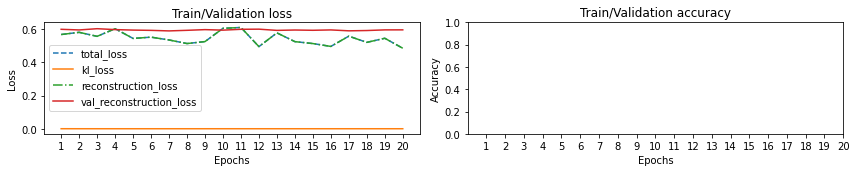

In [145]:
plot_training_histories([modeler.model.history])